In [11]:
import lightgbm as lgb
import shap
import sys
import pandas as pd

sys.path.append('../../../github/module/')
from preprocessing import set_validation, split_dataset, factorize_categoricals, get_dummies
from load_data import pararell_load_data, x_y_split
from convinience_function import get_categorical_features, get_numeric_features
from logger import logger_func
from make_file import make_feature_set

logger = logger_func()

# load JS visualization code to notebook
shap.initjs()

data = pd.read_csv('../data/base.csv')
target = 'TARGET'

' ディレクトリに入ってるfeatureをmerge'
path = '../features/3_winner/*.npy'
dataset = make_feature_set(data, path)
dataset = dataset.set_index('SK_ID_CURR')

train = dataset.query('is_train==1')
logger.info(f'train extract: {train.shape}')
train.drop(['is_train', 'is_test'], axis=1, inplace=True)
logger.info(f'train columns: \n{train.columns}')

dummie=0
categorical = get_categorical_features(train, [])
if dummie==0:
    train = factorize_categoricals(train, categorical)
elif dummie==1:
    train = get_dummies(train, categorical)

train, valid = split_dataset(train, 1)
x_train, y_train = x_y_split(train, target)
x_val, y_val = x_y_split(valid, target)

use_cols = list(x_train.columns)

2018-06-27 18:55:42,656 logger 19 [INFO]    [logger_func] start 
2018-06-27 18:55:42,656 logger 19 [INFO]    [logger_func] start 
2018-06-27 18:55:42,656 logger 19 [INFO]    [logger_func] start 
2018-06-27 18:55:42,656 logger 19 [INFO]    [logger_func] start 


2018-06-27 18:55:52,538 logger 27 [INFO]    [<module>] train extract: (307511, 79) 
2018-06-27 18:55:52,538 logger 27 [INFO]    [<module>] train extract: (307511, 79) 
2018-06-27 18:55:52,538 logger 27 [INFO]    [<module>] train extract: (307511, 79) 
2018-06-27 18:55:52,538 logger 27 [INFO]    [<module>] train extract: (307511, 79) 
/mnt/c/Users/gixo/go/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
2018-06-27 18:55:53,237 logger 29 [INFO]    [<module>] train columns: 
Index(['TARGET', 'valid_no', 'AMT_ANNUITY', 'AMT_CREDIT',
       'AMT_CREDIT_diff_AMT_ANNUITY@_diff_AMT_GOODS_PRICE@',
       'AMT_CREDIT_diff_AMT_ANNUITY@_diff_AMT_INCOME_TOTAL_diff_AMT_ANNUITY@@',
       'AMT_CREDIT_diff_AMT_ANNUITY@_div_AMT_ANNUITY@',
       'AMT_CREDIT_diff_AMT_ANNUITY@_di

../../../github/module/preprocessing.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[col], _ = pd.factorize(data[col])


In [3]:
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

fix_params = {
    'objective': 'binary',
    'learning_rate': 0.1,
    'n_estimators': 3500,
    'subsample': 0.85,
    'num_leaves': 31,
    'max_bin': 255,
    'max_depth': 5,
    'min_child_samples': 13,
    'min_child_weight': 5,
    'min_data_in_bin': 8,
    'min_split_gain': 0,
    'bagging_freq': 1,
    'feature_fraction': 0.2,
    'lambda_l1': 0.2,
    'lambda_l2': 0.3,
    'sigmoid': 1,
    'random_state': 1208
}
early_stopping_rounds = 150

' 学習 '
clf = lgb.train(fix_params,
                lgb_train,
                valid_sets=lgb_eval,
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=200,
                )

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
shap_values = shap.TreeExplainer(clf).shap_values(x_train)


/mnt/c/Users/gixo/go/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[200]	valid_0's binary_logloss: 0.242962
[400]	valid_0's binary_logloss: 0.242906
Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.24284


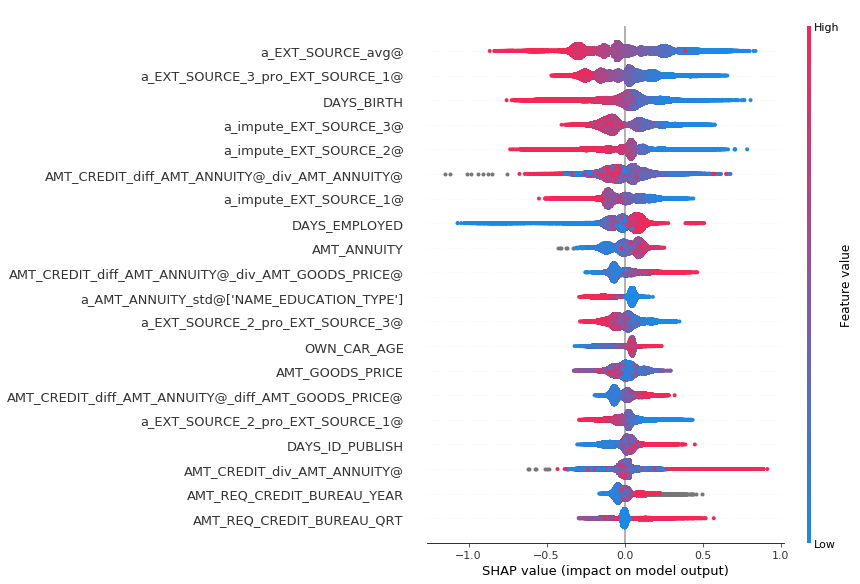

In [7]:
shap.summary_plot(shap_values, x_train)

In [8]:
shap_values.shape

(230632, 76)

In [ ]:
# visualize the first prediction's explanation
for i in range(30):
    shap.force_plot(shap_values[i,:], x_train.iloc[i,:])

In [5]:
from itertools import product
a = [1,2,3]
list(product(a, len(a)))

TypeError: 'int' object is not iterable